# <span style="color:#F72585">Canalización de datos. La API tf.data</span>


## <span style="color:#4361EE">Introducción</span> 

Basado en [tf.data](https://www.tensorflow.org/guide/data).

La API `tf.data` permite crear tuberías de entrada complejas a partir de piezas simples y reutilizables. Por ejemplo, la canalización de un modelo de imagen podría agregar datos de archivos en un sistema de archivos distribuido, aplicar perturbaciones aleatorias a cada imagen y fusionar imágenes seleccionadas al azar en un lote para entrenamiento. La canalización de un modelo de texto puede implicar extraer símbolos de datos de texto sin procesar, convertirlos en identificadores incrustados con una tabla de búsqueda y agrupar secuencias de diferentes longitudes. 

## <span style="color:#4361EE">Importa librerías</span> 

In [1]:
import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## <span style="color:#4361EE">Esenciales</span> 

Para crear una canalización de entrada, debe comenzar con una fuente de datos. Por ejemplo, para construir un `Dataset` de datos a partir de datos en la memoria, puede usar *tf.data.Dataset.from_tensors()* o *tf.data.Dataset.from_tensor_slices()*. Alternativamente, si sus datos de entrada están almacenados en un archivo en el formato *TFRecord* de TensorFlow puede usar *tf.data.TFRecordDataset()*.

El objeto Dataset es un iterable de Python. Esto hace posible consumir sus elementos usando un bucle for:

In [2]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
len(dataset)

6

In [4]:
for elem in dataset:
    print(elem.numpy())

8
3
0
8
2
1


o se pueden crear explícitamente un iterador

In [5]:
it = iter(dataset)
print(next(it).numpy())
print(next(it).numpy())

8
3


### Consumo de datos usando reducción: reduce

In [6]:
print(dataset.reduce(0, lambda state, value: state+value).numpy())

22


## <span style="color:#4361EE">Estructura del conjunto de datos</span> 

Un conjunto de datos produce una secuencia de elementos , donde cada elemento tiene la misma estructura (anidada) de componentes . 

Los componentes individuales de la estructura pueden ser de cualquier tipo representable por *tf.TypeSpec*, incluidos *tf.Tensor* , *tf.sparse.SparseTensor* ,*tf.RaggedTensor* , *tf.TensorArray* o *tf.data.Dataset*.

Las construcciones de Python que se pueden usar para expresar la estructura (anidada) de elementos incluyen *tuple , dict , NamedTuple y OrderedDict*. 

En particular, *list* no es una construcción válida para expresar la estructura de los elementos del conjunto de datos. 

Si desea que una entrada de *list* se trate como una estructura, debe convertirla en tuple y si desea que una lista de salida, entonces debe empaquetarla explícitamente usando *tf.stack*.


La propiedad *Dataset.element_spec* permite inspeccionar el tipo de cada componente del elemento. La propiedad devuelve una estructura anidada de objetos *tf.TypeSpec*, que coincide con la estructura del elemento, que puede ser un solo componente, una tupla de componentes o una tupla anidada de componentes. Por ejemplo:

In [7]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))
print(dataset1)

<TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.float32, name=None)>


In [8]:
for i in dataset1:
    print(i.numpy())

[0.643  0.0768 0.7552 0.8863 0.8816 0.8241 0.6129 0.5465 0.4208 0.6539]
[0.7581 0.5623 0.4041 0.4105 0.0918 0.981  0.4985 0.6426 0.8726 0.0647]
[0.3603 0.9796 0.47   0.6248 0.6526 0.6564 0.5031 0.9662 0.2033 0.7072]
[0.6901 0.279  0.6848 0.0189 0.8153 0.7849 0.4249 0.5168 0.2074 0.6564]


In [9]:
len(dataset1)

4

In [10]:
dataset2 = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4]), #y
     tf.random.uniform([4,100], maxval=100, dtype=tf.int32))) #x

dataset2.element_spec
    

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [11]:
len(dataset2)

4

In [12]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [13]:
len(dataset3)

4

In [14]:
type(dataset3)

tensorflow.python.data.ops.dataset_ops.ZipDataset

In [15]:
i = iter(dataset3)

In [16]:
print(i.next(), "\n")
print(i.next(), "\n")
print(i.next(), "\n")
print(i.next(), "\n")

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.643 , 0.0768, 0.7552, 0.8863, 0.8816, 0.8241, 0.6129, 0.5465,
       0.4208, 0.6539], dtype=float32)>, (<tf.Tensor: shape=(), dtype=float32, numpy=0.41041648>, <tf.Tensor: shape=(100,), dtype=int32, numpy=
array([69, 30, 29, 97, 38, 48, 83, 89, 21, 97,  5, 49, 67,  5, 39, 57,  1,
       81, 25, 75, 85, 72, 98, 88, 75, 52, 82,  7, 38,  5, 45, 46, 20, 75,
       11, 77, 67, 58,  5, 97, 80, 67, 28, 58, 75, 44, 23, 61, 96, 29, 72,
       73, 27, 61, 52, 31, 32, 69, 61, 73,  7, 29, 92, 41,  7, 94, 10, 94,
       96, 24, 46, 62, 10, 71, 40,  0, 54, 31, 53, 19, 96, 90, 72, 46, 23,
       85, 18,  5, 77,  8, 79, 53, 51,  8, 16, 38, 20, 27, 57, 65])>)) 

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.7581, 0.5623, 0.4041, 0.4105, 0.0918, 0.981 , 0.4985, 0.6426,
       0.8726, 0.0647], dtype=float32)>, (<tf.Tensor: shape=(), dtype=float32, numpy=0.9183533>, <tf.Tensor: shape=(100,), dtype=int32, numpy=
array([81, 77, 48, 13, 35, 

In [17]:
for a, (b,c) in dataset3:
    print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


In [18]:
# dataset con tensores dispersos
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0],[1, 2]], values=[1, 2], dense_shape=[3, 4]))
dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [19]:
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

## <span style="color:#4361EE">Leer datos de entrada</span> 

### <span style="color:#4CC9F0">Consumir matrices Numpy</span>


Si todos sus datos de entrada caben en la memoria, la forma más sencilla de crear un Dataset a partir de ellos es convertirlos en objetos tf.Tensor y usar Dataset.from_tensor_slices() .

In [20]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [21]:
imagenes, labels  = train
imagenes = imagenes /255.

dataset = tf.data.Dataset.from_tensor_slices((imagenes, labels))
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

### <span style="color:#4CC9F0">Consumir generadores de Python</span>


In [22]:
def count(stop):
    i=0
    while i<stop:
        yield i
        i+= 1
        
for n in count(5):
    print(n)

0
1
2
3
4


El constructor `Dataset.from_generator` convierte el generador de Python en un `tf.data.Dataset` completamente funcional.

El constructor toma un invocable como entrada, no un iterador. Esto le permite reiniciar el generador cuando llega al final. Toma un argumento args opcional, que se pasa como argumentos del invocable.

El argumento *output_types* es necesario porque *tf.data* crea un *tf.Graph* internamente y los bordes del gráfico requieren un tf.dtype .




In [23]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes=(),)

In [24]:
for count_batch in ds_counter.repeat().batch(10).take(10):
    print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


El argumento `output_shapes` no es necesario, pero se recomienda, ya que muchas operaciones de flujo tensorial no admiten tensores con rango desconocido. Si la longitud de un eje en particular es desconocida o variable, output_shapes puede colcarse como None.

También es importante tener en cuenta que `output_shapes` y `output_types` siguen las mismas reglas de anidamiento que otros métodos de conjuntos de datos.

Aquí hay un generador de ejemplo que demuestra ambos aspectos, devuelve tuplas de matrices, donde la segunda matriz es un vector con longitud desconocida.

In [25]:
def gen_series():
    i = 0
    while True:
        size = np.random.randint(0,10)
        yield i, np.random.normal(size = (size,))
        i+=1

In [26]:
for i, series in gen_series():
    print(i, ":", str(series))
    if i > 5:
        break

0 : [-0.9718 -0.8939]
1 : [ 0.3857  0.0936  0.4761 -0.7076  0.3147]
2 : [ 0.9845  0.2639 -1.2361 -0.2204  1.0877]
3 : [-1.0936 -0.5489  0.1285]
4 : [-0.2768 -0.689  -0.2804 -1.1866  1.1925 -1.2738  1.0818 -1.5897 -0.975 ]
5 : []
6 : [-0.1148 -0.033   0.1099 -0.7879  0.0403  0.6136 -0.781   0.5238]


La primera salida es un *int32* la segunda es un *float32*.

El primer elemento es un escalar, forma () , y el segundo es un vector de longitud desconocida, forma (None,)


In [27]:
ds_series = tf.data.Dataset.from_generator(
    gen_series,
    output_types=(tf.int32, tf.float32),
    output_shapes=((), (None, )))

ds_series

<FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

Ahora se puede utilizar como un *tf.data.Dataset* normal. Tenga en cuenta que al procesar por lotes un conjunto de datos con una forma variable, debe usar *Dataset.padded_batch*.

In [28]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10)

ids, sequence_batch = next(iter(ds_series_batch))

print (ids.numpy())
print()
print(sequence_batch.numpy())

[10  3  6  2 18 16 13 12 17 14]

[[ 0.0332 -0.3953  0.223   0.      0.      0.      0.      0.      0.    ]
 [-0.5322  0.3596  0.3533 -1.0912 -1.1611  0.9808 -0.7938  0.      0.    ]
 [-1.0576  1.9008  0.3463  0.7671 -0.5475  0.9598  1.144   2.0745  0.    ]
 [ 0.3797 -1.0781 -1.0633  0.1672 -2.2933  0.0055 -0.4743  0.      0.    ]
 [-1.2563  1.571   0.1204  0.7617 -0.8964  0.2408  0.1783 -0.5203  0.2615]
 [-0.2508 -0.4216 -0.9025 -1.3927  0.3858 -0.0355  0.      0.      0.    ]
 [ 1.197  -1.3078  0.3241  0.6226 -1.0343  1.1155  0.      0.      0.    ]
 [-1.4451  0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-0.6036  0.7272  0.0259  0.8624  0.9577  0.515   1.4269  0.      0.    ]
 [ 0.2857  0.9669  0.      0.      0.      0.      0.      0.      0.    ]]


In [29]:
it = iter(ds_series_batch)
for i in range(10):
    ids, sequence_batch = next(it)
    print (ids.numpy())
    print()
    print(sequence_batch.numpy())
    print()
    

[10 20  2  6  5  1 12 13  4 24]

[[-0.1098 -0.8508  0.7843  0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.735  -1.3039 -1.9248 -0.9722  0.      0.      0.      0.      0.    ]
 [-0.422  -0.9015  0.      0.      0.      0.      0.      0.      0.    ]
 [ 1.7319  0.1664 -0.9018  0.      0.      0.      0.      0.      0.    ]
 [ 0.1676  0.4205  0.355  -1.0083  0.      0.      0.      0.      0.    ]
 [ 2.1129 -0.2062 -0.1135 -0.3565  0.0222  0.      0.      0.      0.    ]
 [ 0.1981  1.7048 -1.565   1.5483 -0.8894 -3.5365  0.4751  0.      0.    ]
 [ 2.1377 -1.9029 -1.5093 -0.3854 -1.0025  0.0128  0.5573  1.7655  0.0851]
 [-1.9976 -0.7521  0.4225  0.      0.      0.      0.      0.      0.    ]]

[ 3 15 21 22 30 27 28 36 19  9]

[[-1.2541 -1.2011 -1.0994  0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-0.6467 -0.3231  0.      0.   

### <span style="color:#4CC9F0">Ejemplo realista con imágenes</span>


Para obtener un ejemplo más realista, intente `tf.data.Dataset` `preprocessing.image.ImageDataGenerator` como un `tf.data.Dataset` .

Primero descargue los datos:


In [30]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    cache_dir='/media/storage', #dirección de extracción
    cache_subdir='Datasets', #carpeta que se crea para la extracción
    untar=True)

In [31]:
print(flowers)

/tmp\.keras\Datasets\flower_photos


Cree la `image.ImageDataGenerator`

In [32]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [33]:
images, labels = next(image_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [34]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [35]:
ds = tf.data.Dataset.from_generator(
    lambda: image_gen.flow_from_directory(flowers),
    output_types=(tf.float32, tf.float32),
    output_shapes=([32,256,256,3],[32,5]))

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

### <span style="color:#4CC9F0">Consumir datos de texto</span>


Muchos conjuntos de datos se distribuyen como uno o más archivos de texto. `tf.data.TextLineDataset` proporciona una manera fácil de extraer líneas de uno o más archivos de texto. 

Dados uno o más nombres de archivo, un `TextLineDataset` producirá un elemento con valor de cadena por línea de esos archivos.

In [36]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url +file_name)
    for file_name in file_names
]

In [37]:
file_paths

['C:\\Users\\User\\.keras\\datasets\\cowper.txt',
 'C:\\Users\\User\\.keras\\datasets\\derby.txt',
 'C:\\Users\\User\\.keras\\datasets\\butler.txt']

In [38]:
dataset = tf.data.TextLineDataset(file_paths)

Estas son las primeras líneas del primer archivo:

In [39]:
for line in dataset.take(5):
    print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


Para alternar líneas entre archivos, use `Dataset.interleave` . Esto facilita la reproducción aleatoria de archivos. Aquí están la primera, segunda y tercera líneas de cada traducción:

In [40]:
file_ds = tf.data.Dataset.from_tensor_slices(file_paths)

In [41]:
for i in file_ds: print(i.numpy())

b'C:\\Users\\User\\.keras\\datasets\\cowper.txt'
b'C:\\Users\\User\\.keras\\datasets\\derby.txt'
b'C:\\Users\\User\\.keras\\datasets\\butler.txt'


In [42]:
line_ds = file_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(line_ds.take(9)):
    if i%3 ==0:
        print()
    print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


De manera predeterminada, `TextLineDataset` produce todas las lineas de cada archivo, lo cual tal vez no sea lo que se quiera. Tal vez el archivo empieza con el encabezado, o contiene comentarios. Para remover o pasarse estas lineas se usan las transformaciones `Dataset.skip()` o `Dataset.filter()`


A continuación, trabajamos con el archivo de la tragedia del Titanic. Se salta la primera linea, y filtramos para tener solo a los sobrevivientes

In [43]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [44]:
for line in titanic_lines.take(10):
    print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [45]:
def survived(line):
    return tf.not_equal(tf.strings.substr(line,0,1), '0')

survivors=titanic_lines.skip(1).filter(survived)

In [46]:
for line in survivors.take(10):
    print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


### <span style="color:#4CC9F0">Consumir datos CSV</span>


El formato CSV es muy popular para guardar datos tabulares en forma de texto.

Ya subimos el archivo del titanic, el cual es csv. Podemos subirlo en este mismo formato usando pandas 

In [47]:
df=pd.read_csv(titanic_file)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Si se tiene suficiente memoria, pueden transformar a diccionario el Dataframe e importar los datos con facilidad

In [48]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


Un acercamiento más ameno es cargar desde el disco cuando sea necesario.

el modulo tiene métodos para extraer rgistros de uno o más archivos CSV que cumplan con la [RFC 4180](https://tools.ietf.org/html/rfc4180)

la función `experimental.make_csv_dataset` es una interfaz para leer conjuntos de archivos CSV, con lo cual podemos hacer inferencia por columna y crear lotes de los datos

Se puede usar el argumento `select_columns` si solo se necesitan algunas columnas

In [49]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

In [50]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [1 1 0 0]
  'fare'              : [ 7.75 65.    7.75  8.05]
  'class'             : [b'Third' b'Second' b'Third' b'Third']


### <span style="color:#4CC9F0">Consumir conjuntos de archivos</span>


Es normal que los datos estén distribuidos en múltiples archivos, con cada archivo teniendo ejemplos

In [51]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

Cada directorio de la carpeta raíz contiene un directorio de cada clase

In [52]:
for item in flowers_root.glob("*"):
  print(item.name)

daisy
dandelion
LICENSE.txt
roses
sunflowers
tulips


Cada archivo en los directorios son ejemplos

In [53]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\sunflowers\\5556633113_0a04f5ed8a_n.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\daisy\\2087343668_ef4fb95787_n.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\sunflowers\\45045005_57354ee844.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\tulips\\14068378204_7b26baa30d_n.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\roses\\3921794817_276eb4386b.jpg'


usando `tf.io.read_file` podemos ler los datos y extraer las etiquetas, obteniendo (imagen, etiqueta)

In [54]:
def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [55]:
for image_raw, label_text in labeled_ds.take(1):
  print(repr(image_raw.numpy()[:100]))
  print()
  print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00'

b'roses'


## <span style="color:#4361EE">Loteo de elementos del dataset</span>


### <span style="color:#4CC9F0">Loteo simple</span>

La transformación `Dataset.batch()` es la forma más sencilla de hacer un lote de `n` elementos consecutivos. Para cada componente, todos los elementos deben tener un tensor de exactamente la misma dimensión

In [56]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3], dtype=int64), array([ 0, -1, -2, -3], dtype=int64)]
[array([4, 5, 6, 7], dtype=int64), array([-4, -5, -6, -7], dtype=int64)]
[array([ 8,  9, 10, 11], dtype=int64), array([ -8,  -9, -10, -11], dtype=int64)]
[array([12, 13, 14, 15], dtype=int64), array([-12, -13, -14, -15], dtype=int64)]


### <span style="color:#4CC9F0">Loteo de tensores con acolchamiento</span>


Con el loteo simple todos los tensores debe tener la misma dimensión, pero esto no va a ser el caso todas las veces. Utilizando `Dataset.padded_batch` se hace un acolchamiento de los tensores de distintas formas, específicando las dimensiones a las cuales hay que aplicar acolchamiento

In [57]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



## <span style="color:#4361EE">Flujo de entrenamiento</span>


### <span style="color:#4CC9F0">Procesando múltiples epochs</span>


La API ofrece dos maneras dde procesar múltiples epochs de los mismos datos.

La primera manera es iterando sobre el el conjunto de datos utilizando `Dataset.repeat()`. volvemos al ejemplo de texto del Titanic. 

In [58]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

`Dataset.repeat` hace una concatenación de los argumentos sin señalar el inicio o el final de un epoch. Si aplicamos
`Dataset.batch` Después de esta, se producirán lotes que van más allá de los límites e los epochs.

Si la función `repeat` no tiene argumentos, se hara una repetición infinita.

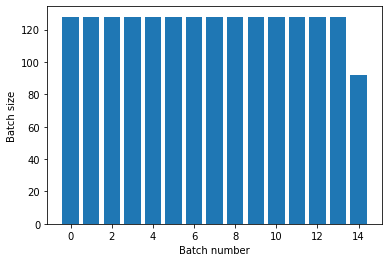

In [59]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

si queremos una separación clara de los epoch, se aplica `Dataset.batch` antes de `repeat`

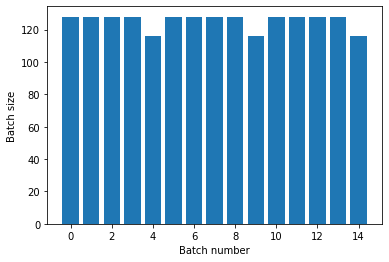

In [60]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

Si queremos, por ejemplo, recopilar estadísticas al final de cada epoch, podemos hacer una iteración y reiniciar después de cada epoch

In [61]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


## <span style="color:#4361EE">Mezclar los dato de entrada</span>


la transformación `Dataser.shuffle()` toma una muestra de un tamaño predeterminado y selecciona el siguiente dato del buffer.

Le agregaremos un indice a los datos del titanic para que el efecto sea visible

In [62]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [63]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[  4  55  31  35  86  85  33  10  88  48   5   6  13  75  95  93  53 110
  43  81]


`shuffle` no señala el fin de un epoch hasta que el buffer esté vacío. si aplicamos `repeat` antes de este, se podrá ver el momento en el que termina un epoch y empieza otro

In [64]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("esta es la lista de indices cercanos al fin del epoch:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

esta es la lista de indices cercanos al fin del epoch:

[617 446 622 503 610 599 417 627 594 572]
[609 520 385 623 589 470 525 577 561 208]
[591 321 462 398 568 626 485 586]
[29  8 28 97 81 68 87 91 89 57]
[107  61  77   4  60 106  73  48 115  30]


gráficamente se puede apreciar mejor

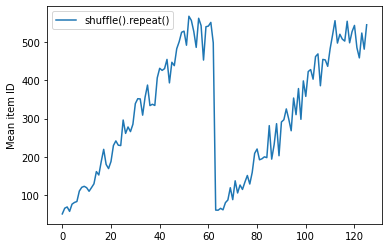

In [65]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

si ponemos `repeat`antes de la mezcla, los límites de los epoch se mantendrán iguales hasta que no hayan más objetos que mezclar

In [66]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("esta es la lista de indices cercanos al fin del epoch:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

esta es la lista de indices cercanos al fin del epoch:

[616 610 591 560 612 618 493 501  13 328]
[558  20 505 550 541  36 564   2 576 611]
[614 609   4   3 544  35 556  42 483 337]
[405  33 474  29 554 580 280 575 484  38]
[415  57 579 503  63   1  23 599 584  37]
[ 28  19 625  32 624 594  24 488 507  10]
[  0 602  73 569 622 551  54  61 615  74]
[531 448  69  52  71  82  21 613 547 587]
[  9  59  90 103   8  65  45 586  78 589]
[ 49 360  60 571  51  22 318  97  87  80]
[620  70  91 113  86  84 449  89  88 119]
[561  25  48  68  39  26 108  95 486   5]
[110  96  66  46 100 121  11  56 128 472]
[126 159 138 619 123  75 139 133 621 605]
[627 143 112 136  47 581  30 127 149  81]


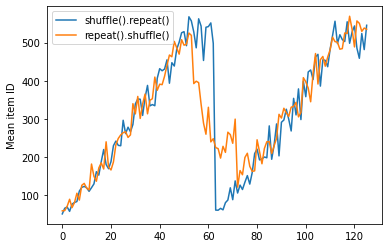

In [67]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## <span style="color:#4361EE">Preprocesamiento de datos</span>


si se quiere aplicar alguna función a los datos en cuestión, se utiliza  la transformación `Dataset.map(f)`. Esta toma los objetos `t f.Tensor` de un solo elemento y saca nuevos objetos en un nuevo conjunto de datos.

Aquí mostramos dos ejemplos muy comunes de pre procesamiento

### <span style="color:#4CC9F0">Decodificando imagenes y cambiar su tamaño</span>


Al trabajar con imagenes de la vida cotidiana, lo más probable es que necesitemos estandarizar los tamaños a uno en común. 

Utilizaremos la lista de flores para este ejemplo

In [68]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

escribimos una función para manipular datos

In [69]:
# Lee una imagen de un archivo, la decodifica en un tensor y cambia su tamaño
# a una forma predeterminada
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

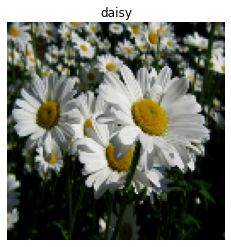

In [70]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

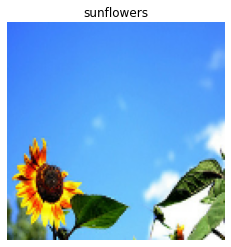

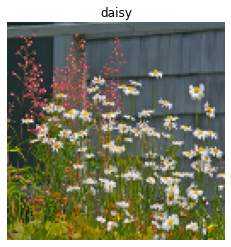

In [71]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

### <span style="color:#4CC9F0">Aplicando funciones de Python</span>


Por razones de rendimiento, es mejor usar únicamente funciones de Tensorflow para manipular datos, pero a veces es necesario usar herramientas de otros paquetes de python.

Para esto utilizamos `tf.py_function()` como función en `Dataset.map()`

Supongamos que queremos hacer una rotación aleatoria en un conjunto dde imágenes. Tensorflow sólo tiene `tf.image.rot90`, lo cual no sirve para la intención que se tiene. por suerte, el paquete scipy cuenta con `scipy.ndimage.rotate`

In [72]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


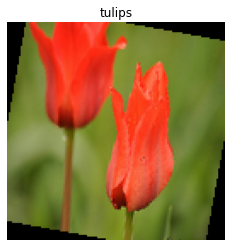

In [73]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

In [74]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


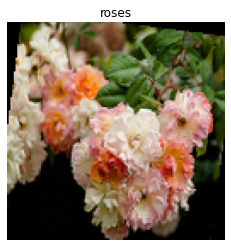

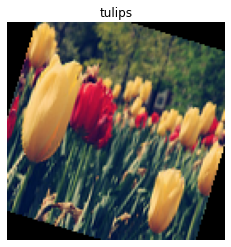

In [75]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

## <span style="color:#4361EE">Ventaneo de series de tiempo</span>


En el caso de modelos de series de tiempo, estos datos están organizados con el axis de tiempo intacto. Muchas veces se le alimentaran secciones de tiempo adyacentes a los modelos como datos. Hay dos maneras de generar estos cortes. La primera es utilizando lotes:

In [76]:
range_ds = tf.data.Dataset.range(100000)

In [77]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


Para hacer predicciones un paso hacia el futuro, es ideal mover los datos y etiquetas un paso relativo a ellos

In [78]:
def dense_1_step(batch):
  # Se mueven las características y etiquetas un paso hacia la derecha
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


Para predecir una ventana completa de tiempo, podemos separar los lotes en dos partes

In [79]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Se toman los primeros 10 pasos
          batch[-5:])   # se toma el residuo

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


Para permitir que se superpongan las características de un lote y las etiquetas de otro, podemos usar `Dataset.zip()`

In [80]:
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52]


Por supuesto, a veces se necesitan más control de las ventanas. Razón por la que se puede usar `Dataset.window`, pero para usarla correctamente, necesitamos algo de cuidado en lso datos. Esta transformación retorna un conjunto de conjuntos de datos

In [81]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


¿Pero qué pasó aquí? para ver los datos como un solo conjunto, usamos `Dataset.flat_map`. Al mismo tiempo casi siempre es necesario hacer lotes

In [82]:
for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

In [83]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


Haciéndolo todo junto, obtendríamos una función como esta

In [84]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows

In [85]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


Es sencillo extraer etiquetas con estos datos

In [86]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


## <span style="color:#4361EE">Remuestreo</span>


Es usual encontrarse con datasets desbalanceados a nivel de clases. Es buena idea aquí el hacer un remuestreo del dataset. `tf.data` da dos métodos para esto

Se usará el dataset de fraude de tarjetas de crédito es perfecto para demostrarlo

In [87]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    cache_dir='/media/storage',
    cache_subdir='Datasets',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

In [88]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

Se revisará ahora la distribución de las clases a clasificar, para ver qué tan sesgados están

In [89]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [90]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9963 0.0037]


Para poder trabajar con datos desbalanceados, la mejor idea es balancearlos. Aquí algunos métodos para esto

### <span style="color:#4CC9F0">Muestreo de Datasets</span>


La forma más sencilla es usar `sample_from_datasets`. Esto es particularmente mejor cuando se tienen datasets separados por clase. Para este caso se va a filtrar los datos de fraude para esta razón

In [91]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

In [92]:
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


Se pasarán los datasets, junto con los pesos que se quieren por `tf.data.experimental.sample_from_datasets`

In [93]:
balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


Ahora se generarán ejemplos de las clases con una probabilidad 50/50

In [94]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 0 1 0 0 0 1 1 0 1]
[0 1 1 1 0 0 0 1 0 0]
[0 0 1 1 0 0 1 1 0 1]
[1 0 0 0 0 0 0 0 0 1]
[0 1 0 1 1 1 1 0 0 1]
[1 1 1 0 0 1 1 1 1 0]
[1 0 1 1 1 0 1 1 0 0]
[1 0 1 1 0 0 1 1 1 0]
[0 1 0 0 0 1 0 1 1 0]
[0 1 0 1 1 0 0 0 0 0]


## <span style="color:#4361EE">Remuestreo de rechazo</span>


Como se dijo, necesitamos que los datasets estén separados por clase. Podemos por supuesto usar `Dataset.filter`, pero eso haría que los datos se cargaran dos veces.

La función `data.experimental.rejection_resample` permite rebalancear los datos sin tener que cargarlos otra vez. Esto se logra eliminando elementos del dataset para llegar al balance.

Esta función toma un argumento `class_func`. Esta función es aplicada a cada elemento del dataset para determinar la clase que tiene.

Los elementos de `creditcard_ds` ya están separados en pares `(features,label)`. Así que la función solo tiene que retornar la etiqueta

In [95]:
def class_func(features, label):
  return label

De igual forma es necesaria una distribución objetivo y preferiblemente un estimado de esta

In [96]:
resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=[0.5, 0.5], initial_dist=fractions)

Instructions for updating:
Use `tf.data.Dataset.rejection_resample(...)`.


`resampler` trabaja con las observaciones de manera individual, así que hay que aplicar `unbatch()` antes.

In [97]:
resample_ds = creditcard_ds.unbatch().apply(resampler).batch(10)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



el resampler retorna pares del tipo `(class, example)` a partír de la salida de `class_func`. En este caso ya tenemos `(feature, label)`, así que se hace un map para obtener una copia extra de las etiquetas

In [98]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [99]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 0 0 0 0 0 0 1 1 0]
[1 1 1 0 1 0 1 0 0 1]
[0 1 1 1 1 1 1 1 0 0]
[1 0 0 1 0 0 0 1 1 1]
[0 0 0 1 0 1 0 0 0 1]
[1 1 1 1 1 1 0 1 1 1]
[1 1 0 0 1 0 0 1 1 1]
[0 0 1 1 1 0 1 1 1 0]
[1 1 1 0 0 0 1 1 0 0]
[1 0 0 0 1 1 1 0 1 1]


¿Cuál es el problema de este método? si el desbalanceo es muy grande, se va a perder una cantidad muy grande de datos. ¿Qué es más importante: La cantidad de datos o la cantidad de recursos?